In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import re
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np
import os



In [62]:
path = 'c:/Users/Pietro/Desktop/Porosities/Porosities/'
os.chdir(path)

In [63]:
from Lib.Data import PorosityDistribution, extract_microstructures
from Lib.Datasets import  PorosityDataset

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
sample_path = os.getcwd()+'/Job_Assignment_Data/'

In [66]:
# Create train, validation, and test datasets
train_dataset = PorosityDataset(sample_path, train=True, val=False, test=False,keep_doubles=False,device=device)
val_dataset = PorosityDataset(sample_path, train=False, val=True, test=False,keep_doubles=False,device=device)
test_dataset = PorosityDataset(sample_path, train=False, val=False, test=True,keep_doubles=False,device=device)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1280, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1280, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1280, shuffle=False)

In [67]:
print(train_dataset.__len__())

297600


In [68]:
import torch.nn as nn

In [69]:
class ResidualModuleBlock(nn.Module):
    def __init__(self, dim, steps, dropout=0.1, residual=False, batch_norm=True):
        super(ResidualModuleBlock,self).__init__()
        self.layers = nn.ModuleList()
        self.residual = residual
        
        for i in range(steps):
            self.layers.append(nn.Linear(dim, dim))
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(dim))
            self.layers.append(nn.SiLU())
            self.layers.append(nn.Dropout(dropout))
            
    def forward(self,x):
        residual = x
        for layer in self.layers:
            x = layer(x)
        if self.residual:
            x += residual
        return x
        
class LinearModuleBlock(nn.Module):
    def __init__(self, dims, dropout=0.1, batch_norm=True):
        super(LinearModuleBlock,self).__init__()
        self.layers = nn.ModuleList()
        
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(dims[i+1]))
            self.layers.append(nn.SiLU())
            self.layers.append(nn.Dropout(dropout))
            
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [70]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self,scale=1,condition_dim=0):
        super(Encoder, self).__init__()
        self.scale = scale

        # Linear Layers with Dropout
        
        self.input_block = LinearModuleBlock([3+condition_dim,scale*8,scale*16])
        self.deep_block = ResidualModuleBlock(scale*16,2,residual=True)


    def forward(self, x):
        x = self.input_block(x)
        x = self.deep_block(x)

        return x

class Decoder(nn.Module):
    def __init__(self, scale=1):
        super(Decoder, self).__init__()
        self.scale = scale
        # Linear Layers with Dropout
        
        self.linproj = nn.Linear(scale*8,3)
        self.output_block = LinearModuleBlock([scale*16,scale*8])
        self.deep_block = ResidualModuleBlock(scale*16,4,residual=False)


    def forward(self, x):
        
        x = self.deep_block(x)
        x = self.output_block(x)
        
        return self.linproj(x)

In [71]:
(X,y) = next(iter(train_dataloader))
print(X.shape,y.shape)

torch.Size([1280, 3]) torch.Size([1280])


In [72]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [73]:
X.shape

torch.Size([1280, 3])

In [74]:
hidden = encoder(X)
out = decoder(hidden)
out.shape

torch.Size([1280, 3])

In [75]:
import torch.nn as nn

class ConditionedVAE(nn.Module):
    def __init__(self, scale=1):
        super(ConditionedVAE, self).__init__()
        self.scale = scale
        self.encoder = Encoder(scale=scale)
        self.decoder = Decoder(scale=scale)
        
        self.condition_encoder = LinearModuleBlock([1,scale*8,scale*16])
        # Add layers for mean and variance of the latent space
        self.fc_mu =nn.Linear(scale*16,scale*16)
        self.fc_logvar = nn.Linear(scale*16,scale*16)  # Output dimension for log variance


    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from the latent space."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, y):

        # Encode the input
        h = self.encoder(x)

        # Get mean and log variance
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Sample from the latent space
        z = self.reparameterize(mu, logvar)
        
        # Add Conditioning
        
        
        z += z + self.condition_encoder(y.view(-1,1))
        
        # Decode the latent representation
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
    def sample(self,num_samples,density,device):
        
        z = torch.randn(num_samples,16*self.scale).to(device)
        y = density*torch.ones(num_samples,1).to(device)
        
        z += z + self.condition_encoder(y)
        samples = self.decoder(z)
        return samples

In [76]:
import torch.nn as nn

class ConditionedVAE2(nn.Module):
    def __init__(self, scale=1):
        super(ConditionedVAE2, self).__init__()
        self.scale = scale
        self.encoder = Encoder(scale=scale)
        self.decoder = Decoder(scale=2*scale)
        
        self.condition_encoder = LinearModuleBlock([1,8,8])
        self.condition_decoder = LinearModuleBlock([1,scale*8,scale*16])
        # Add layers for mean and variance of the latent space
        self.fc_mu =nn.Linear(scale*16,scale*16)
        self.fc_logvar = nn.Linear(scale*16,scale*16)


    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from the latent space."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, y):

        # Encode the input
        
        h = self.encoder(x)

        # Get mean and log variance
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Sample from the latent space
        z = self.reparameterize(mu, logvar)
        
        # Add Conditioning
        
        
        z = torch.cat((z,self.condition_decoder(y.view(-1,1))),dim=-1)
        
        # Decode the latent representation
        x_recon = self.decoder(z)

        return x_recon, mu, logvar
    
    def sample(self,num_samples,density,device):
        
        z = torch.randn(num_samples,16*self.scale).to(device)
        y = density*torch.ones(num_samples,1).to(device)
        
        z  = torch.cat((z,self.condition_decoder(y)),dim=-1)
        samples = self.decoder(z)
        return samples

In [77]:
(X,y) = next(iter(train_dataloader))
print(X.shape,y.shape)

torch.Size([1280, 3]) torch.Size([1280])


In [78]:
torch.cat((X,y.view(-1,1)),dim=1).shape

torch.Size([1280, 4])

In [79]:
print(X[0],y[0])

tensor([0.1724, 0.3103, 0.8621]) tensor(0.1860)


In [80]:
(X,y) = next(iter(train_dataloader))
model = ConditionedVAE(scale=4)
model.to(device)
model(X,y)

(tensor([[ 0.2566, -0.1790, -0.1915],
         [ 0.9318,  1.1031,  0.4529],
         [-0.2388, -0.3216, -0.2226],
         ...,
         [ 0.1834,  0.0146, -0.1332],
         [ 0.3014, -0.2545, -0.1028],
         [ 0.1616, -0.0735, -0.0587]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1983, -0.3487,  0.1721,  ..., -0.3372, -0.3681,  0.1932],
         [ 0.2384, -0.2261,  1.1334,  ...,  0.7055, -1.5151,  1.5879],
         [ 0.9989,  0.2855, -0.1232,  ..., -0.3148, -0.3219,  0.2033],
         ...,
         [ 0.4404,  0.6028, -1.1894,  ...,  0.2670, -0.7277, -0.0607],
         [ 0.0979,  0.7078, -0.7682,  ..., -0.2424,  0.0497,  0.0630],
         [ 0.2085, -0.3263, -0.0043,  ...,  0.3559, -0.4453, -0.5283]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.2345,  0.1156, -0.0152,  ..., -0.2727, -0.6417,  0.4810],
         [ 1.4811, -0.9289, -0.2737,  ..., -0.2910,  0.1082,  0.4535],
         [ 0.0247, -0.6906,  0.3721,  ..., -0.5043,  0.6698, -0.1088],
         ...,
         [-0.5135,  0.0592,

In [81]:
model(X,y)

(tensor([[ 0.3979,  0.0652,  0.1652],
         [ 0.1553, -0.1139, -0.2938],
         [ 0.1743, -0.1958,  0.2246],
         ...,
         [-0.0066,  0.1918, -0.0338],
         [-0.1253, -0.1321, -0.0359],
         [ 0.5592, -0.0372, -0.0730]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0563, -0.2312,  0.1145,  ..., -0.3894, -0.6052, -0.0838],
         [-0.1629,  0.3943,  0.2950,  ...,  0.5616, -2.0447,  1.0521],
         [ 0.2649, -0.0730,  0.0107,  ..., -0.5162, -0.3566,  0.2972],
         ...,
         [ 0.2064, -0.3551, -0.6178,  ..., -0.5747, -0.5189, -0.5102],
         [-0.1704,  0.9048, -0.8569,  ..., -0.2241, -0.0669,  0.4437],
         [ 0.0532, -0.0662, -0.0853,  ..., -0.4558, -0.0173,  0.2488]],
        grad_fn=<AddmmBackward0>),
 tensor([[-0.0981,  0.1663, -0.1093,  ..., -0.3304, -0.0431,  0.5666],
         [ 0.1156, -0.2907, -0.6636,  ..., -0.2566, -0.3328,  0.7929],
         [ 0.5245, -0.2508,  0.1617,  ..., -0.9618,  0.0121,  0.2480],
         ...,
         [-0.7365,  0.7210,

In [82]:
import torch.optim as optim

# Define the optimizer

optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [83]:
# Define the loss function
criterion_reconstruction = nn.L1Loss()

In [84]:
# Training loop
num_epochs = 1

train_losses = []
train_recon_losses = []
train_cond_losses = []
train_kl_losses = []
val_losses = []
val_recon_losses = []
val_cond_losses = []
val_kl_losses = []
beta = 1e-3

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    running_train_recon_loss = 0.0
    running_train_kl_loss = 0.0

    for i, (inputs, conditions) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        outputs, mu, logvar = model(inputs, conditions)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Calculate individual losses
        loss_reconstruction = criterion_reconstruction(outputs, inputs)

        # Combine losses with weights 
        loss = loss_reconstruction + beta*kl_loss 

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_recon_loss += loss_reconstruction.item()
        running_train_kl_loss += kl_loss.item()


    epoch_train_loss = running_train_loss / len(train_dataloader)
    epoch_train_recon_loss = running_train_recon_loss / len(train_dataloader)
    epoch_train_kl_loss = running_train_kl_loss / len(train_dataloader)

    # Validation
    model.eval()
    running_val_loss = 0.0
    running_val_recon_loss = 0.0
    running_val_kl_loss = 0.0

    with torch.no_grad():
        for i, (inputs, conditions) in enumerate(val_dataloader):
            
            outputs, mu, logvar = model(inputs, conditions)

            # Calculate individual losses
            loss_reconstruction = criterion_reconstruction(outputs, inputs)
            
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Combine losses with weights 
            loss = loss_reconstruction + beta*kl_loss #

            running_val_loss += loss.item()
            running_val_recon_loss += loss_reconstruction.item()
            running_val_kl_loss += kl_loss.item()

    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_recon_loss = running_val_recon_loss / len(val_dataloader)

    epoch_val_kl_loss = running_val_kl_loss / len(val_dataloader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} "
          f"Train Reconstruction Loss: {epoch_train_recon_loss:.4f} "
          f"Train KL Loss: {epoch_train_kl_loss:.4f} "
          f"Val Loss: {epoch_val_loss:.4f} "
          f"Val Reconstruction Loss: {epoch_val_recon_loss:.4f} "
          f"Val KL Loss: {epoch_val_kl_loss:.4f} ")

    train_losses.append(epoch_train_loss)
    train_recon_losses.append(epoch_train_recon_loss)
    train_kl_losses.append(epoch_train_kl_loss)
    val_losses.append(epoch_val_loss)
    val_recon_losses.append(epoch_val_recon_loss)
    val_kl_losses.append(epoch_val_kl_loss)


print("Finished Training")

Epoch [1/1] Train Loss: 1.7716 Train Reconstruction Loss: 0.2806 Train KL Loss: 1490.9946 Val Loss: 0.2704 Val Reconstruction Loss: 0.2525 Val KL Loss: 17.8770 
Finished Training


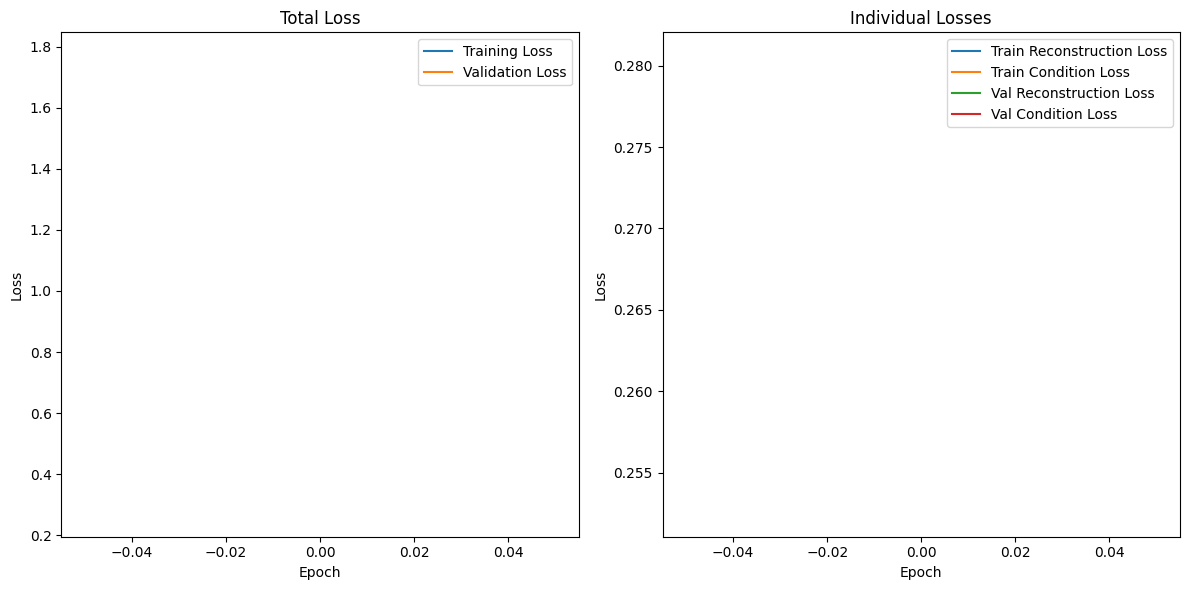

In [85]:
# Plotting (after the training loop)
plt.figure(figsize=(12, 6))

# Total loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Total Loss')

# Individual losses
plt.subplot(1, 2, 2)
plt.plot(train_recon_losses, label='Train Reconstruction Loss')
plt.plot(train_cond_losses, label='Train Condition Loss')
plt.plot(val_recon_losses, label='Val Reconstruction Loss')
plt.plot(val_cond_losses, label='Val Condition Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Individual Losses')

plt.tight_layout()
plt.show()

In [86]:
samples = 500
density = 0.
model.eval()

ConditionedVAE(
  (encoder): Encoder(
    (input_block): LinearModuleBlock(
      (layers): ModuleList(
        (0): Linear(in_features=3, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): SiLU()
        (7): Dropout(p=0.1, inplace=False)
      )
    )
    (deep_block): ResidualModuleBlock(
      (layers): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [87]:
y

tensor([0.6480, 0.4010, 0.7490,  ..., 0.3000, 0.6740, 0.5310])

In [88]:

samples = 500
density = 0.683
model.eval()

rec = model.sample(samples,density,device=device)
df = pd.DataFrame(rec.detach().to('cpu').numpy(),columns=['x','y','z'])
fig = px.scatter_3d(df,x='x',y='y',z='z')
fig.show()
fig = px.histogram(df,facet_col='variable',histnorm='probability',nbins=100)
fig.show()


In [89]:

samples = 500
density = 0.5
model.eval()

rec = model.sample(samples,density,device=device)
df = pd.DataFrame(rec.detach().to('cpu').numpy(),columns=['x','y','z'])
fig = px.scatter_3d(df,x='x',y='y',z='z')
fig.show()
fig = px.histogram(df,facet_col='variable',histnorm='probability',nbins=100)
fig.show()

In [90]:
samples = 500
density = 0.8
model.eval()

rec = model.sample(samples,density,device=device)
df = pd.DataFrame(rec.detach().to('cpu').numpy(),columns=['x','y','z'])
fig = px.scatter_3d(df,x='x',y='y',z='z')
fig.show()
fig = px.histogram(df,facet_col='variable',histnorm='probability',nbins=100)
fig.show()